In [73]:
# Import necessary libraries
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import glob


def get_measurement(file_dir):

    # Specify the directory containing the .fit files (replace with your actual path)
    file_paths = sorted(glob.glob(file_dir + "*.fit"))

    # Initialize lists to store combined data and time axis
    combined_data = []
    time_offset = 0  # To manage time axis across multiple files
    time_axes = []  # To concatenate time axes properly

    # Loop through each .fit file
    for file_path in file_paths:
        hdul = fits.open(file_path)
        
        # Access data (assuming it's a 2D array with shape [frequency, time])
        data = hdul[0].data
        
        # Extract time axis (dummy axis if not provided in the header)
        time_axis = np.arange(data.shape[1]) + time_offset
        time_axes.append(time_axis)
        
        # Append data to the combined list
        combined_data.append(data)
        
        # Update time offset for the next file
        time_offset += data.shape[1]
        
        # Close the file
        hdul.close()

    # Concatenate all data and time axes
    combined_data = np.hstack(combined_data)  # Combine along the time axis
    time_axis_combined = np.hstack(time_axes)  # Combined time axis
    freq_axis = np.arange(combined_data.shape[0])  # Dummy frequency axis

    return time_axis_combined, freq_axis, combined_data






In [74]:

import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

def moving_average_smooth(data, window_size=3):
    """
    Smooths a 2D array along the first axis using a moving average.

    Parameters:
        data (ndarray): 2D array to be smoothed.
        window_size (int): Size of the moving average window.

    Returns:
        ndarray: Smoothed 2D array.
    """
    smoothed_data = np.apply_along_axis(
        lambda x: np.convolve(x, np.ones(window_size)/window_size, mode='same'),
        axis=0,
        arr=data
    )
    return smoothed_data


def gaussian(x, I, mu, sigma, A, B):
    return I * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2)) + A*x + B


def theoretical_fit(x, S, V, omega, delta):
    return S*(1+V*np.sin(omega*x+delta))






In [75]:
def get_V_Bl_fromOneChannel(time, data, freq=0, printbool=False):
    try:
        if printbool:
            print(f"Channel {freq}")
        # Apply smoothing
        #data = moving_average_smooth(data, window_size=10)

        # Fit the Gaussian function (using example Gaussian-like data)
        gaussian_params, _ = curve_fit(gaussian, time, data, p0=[17.5, 5720, 4640, 0, 140])
        I, mu, sigma, A, B = gaussian_params

        # Generate fitted values for plotting
        fitted_gaussian_linear = gaussian(time, I, mu, sigma, A, B)
        fitted_gaussian = gaussian(time, I, mu, sigma, 0, 0)


        if printbool:
            # Gaussian plot
            plt.plot(time, data, label="Data (Gaussian)", color="green")
            plt.plot(time, fitted_gaussian_linear, label=f"Fit: I={I:.2f}, μ={mu:.2f}, σ={sigma:.2f}, A={A:.2f}B={B:.2f}", color="purple")
            plt.title("Gaussian Fit")
            plt.xlabel("Time")
            plt.ylabel("Data")
            plt.legend()

            plt.tight_layout()
            plt.show()

        linear = A*time + B
        data = data - linear
        data = data/fitted_gaussian


        fit_params, _ = curve_fit(theoretical_fit, time, data, p0=[1, 0.035, 0.0043, 5.6])
        S, V, omega, delta = fit_params

        if printbool:
            # Generate fitted values for plotting
            fitted = theoretical_fit(time, S, V, omega, delta)
            plt.plot(time, data, label="Data", color="green")
            plt.plot(time, fitted, label=f"Fit", color="purple")
            plt.title("Fit")
            plt.xlabel("Time")
            plt.ylabel("Data")
            plt.legend()

            plt.tight_layout()
            plt.show()
        

        return abs(V), abs(omega/(2*np.pi)*240)
        

    except Exception as e:
        # Log the exception for debugging purposes if needed
        print(f"Fit failed at channel {freq}: {e}")
        return 0, 0

Channel 20


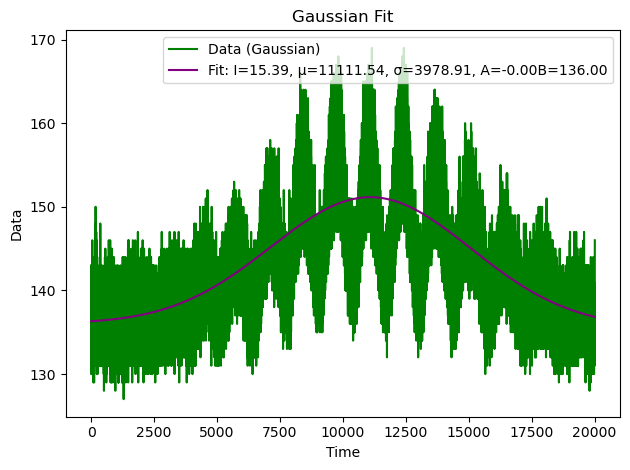

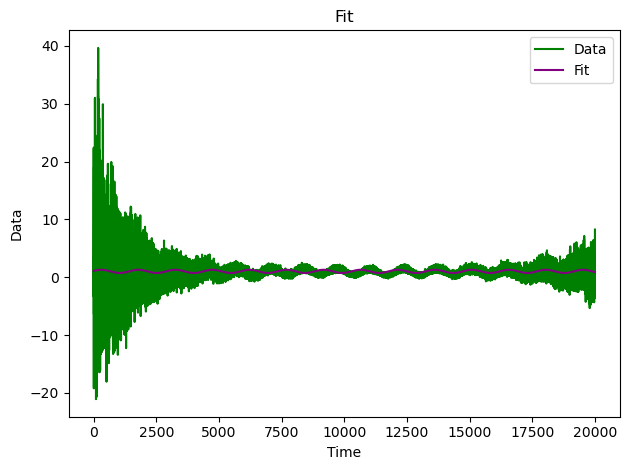

Fit failed at channel 3: Optimal parameters not found: Number of calls to function has reached maxfev = 1200.
Fit failed at channel 5: Optimal parameters not found: Number of calls to function has reached maxfev = 1200.
Fit failed at channel 39: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.
Fit failed at channel 42: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.
Fit failed at channel 52: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.
Fit failed at channel 53: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.
Fit failed at channel 81: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.
Fit failed at channel 87: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.


/tmp/ipykernel_103909/2546352511.py:31: RuntimeWarning: divide by zero encountered in divide
  data = data/fitted_gaussian
/tmp/ipykernel_103909/2546352511.py:31: RuntimeWarning: overflow encountered in divide
  data = data/fitted_gaussian


Fit failed at channel 90: array must not contain infs or NaNs
Fit failed at channel 91: array must not contain infs or NaNs
Fit failed at channel 91: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.
Fit failed at channel 92: Optimal parameters not found: Number of calls to function has reached maxfev = 1200.
Fit failed at channel 92: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.
Fit failed at channel 93: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.


/tmp/ipykernel_103909/2546352511.py:9: OptimizeWarning: Covariance of the parameters could not be estimated
  gaussian_params, _ = curve_fit(gaussian, time, data, p0=[17.5, 5720, 4640, 0, 140])
/home/vinzenz/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/tmp/ipykernel_103909/2546352511.py:34: OptimizeWarning: Covariance of the parameters could not be estimated
  fit_params, _ = curve_fit(theoretical_fit, time, data, p0=[1, 0.035, 0.0043, 5.6])


Fit failed at channel 95: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.
Fit failed at channel 96: array must not contain infs or NaNs
Fit failed at channel 96: array must not contain infs or NaNs
Fit failed at channel 97: array must not contain infs or NaNs
Fit failed at channel 98: array must not contain infs or NaNs
Fit failed at channel 103: Optimal parameters not found: Number of calls to function has reached maxfev = 1200.
Fit failed at channel 104: Optimal parameters not found: Number of calls to function has reached maxfev = 1200.
Fit failed at channel 105: Optimal parameters not found: Number of calls to function has reached maxfev = 1200.
Fit failed at channel 105: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.
Fit failed at channel 105: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.
Fit failed at channel 106: Optimal parameters not found: Number of calls to funct

In [76]:

file_dir_1 = "sun_meas_25/meas_1/"
file_dir_2 = "sun_meas_25/meas_2/"
file_dir_3 = "sun_meas_25/meas_3/"
file_dir_4 = "sun_meas_25/meas_4/"

time_1, freq_1, data_1 = get_measurement(file_dir_1)
time_2, freq_2, data_2 = get_measurement(file_dir_2)
time_3, freq_3, data_3 = get_measurement(file_dir_3)
time_4, freq_4, data_4 = get_measurement(file_dir_4)

frequency_index = 20  # Example: choose the 50th frequency
chosen_frequency = data_1[frequency_index]  # Get the actual frequency value if freq_axis is defined
frequency_range = np.arange(0,200)

V, Blambda = get_V_Bl_fromOneChannel(time_3, data_3[frequency_index],frequency_index, printbool=True)


visibilities_1 = np.empty(len(frequency_range), dtype=float)
Bl_1 = np.empty(len(frequency_range), dtype=float)
visibilities_2 = np.empty(len(frequency_range), dtype=float)
Bl_2 = np.empty(len(frequency_range), dtype=float)
visibilities_3 = np.empty(len(frequency_range), dtype=float)
Bl_3 = np.empty(len(frequency_range), dtype=float)
visibilities_4 = np.empty(len(frequency_range), dtype=float)
Bl_4 = np.empty(len(frequency_range), dtype=float)


for i, freq in enumerate(frequency_range):
    #print(freq)
    visibilities_1[i], Bl_1[i] = get_V_Bl_fromOneChannel(time_1, data_1[freq], freq)
    visibilities_2[i], Bl_2[i] = get_V_Bl_fromOneChannel(time_2, data_2[freq], freq)
    visibilities_3[i], Bl_3[i] = get_V_Bl_fromOneChannel(time_3, data_3[freq], freq)
    visibilities_4[i], Bl_4[i] = get_V_Bl_fromOneChannel(time_4, data_4[freq], freq)



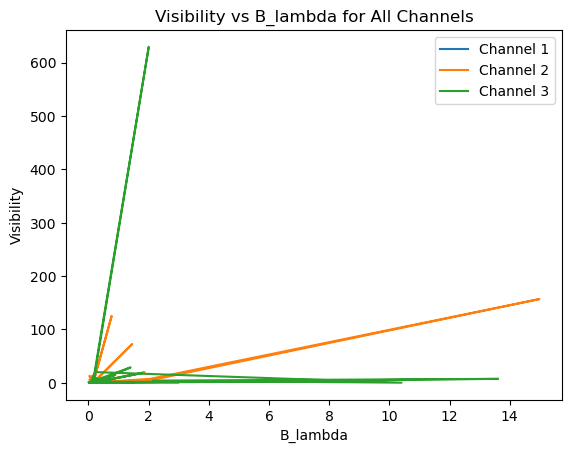

In [77]:
# Filter out (0, 0) values for all four channels
valid_indices_1 = [(omega, visibility) for omega, visibility in zip(Bl_1, visibilities_1) if not (omega == 0 and visibility == 0)]
filtered_Bl_1, filtered_visibilities_1 = zip(*valid_indices_1) if valid_indices_1 else ([], [])

valid_indices_2 = [(omega, visibility) for omega, visibility in zip(Bl_2, visibilities_2) if not (omega == 0 and visibility == 0)]
filtered_Bl_2, filtered_visibilities_2 = zip(*valid_indices_2) if valid_indices_2 else ([], [])

valid_indices_3 = [(omega, visibility) for omega, visibility in zip(Bl_3, visibilities_3) if not (omega == 0 and visibility == 0)]
filtered_Bl_3, filtered_visibilities_3 = zip(*valid_indices_3) if valid_indices_3 else ([], [])

valid_indices_4 = [(omega, visibility) for omega, visibility in zip(Bl_4, visibilities_4) if not (omega == 0 and visibility == 0)]
filtered_Bl_4, filtered_visibilities_4 = zip(*valid_indices_4) if valid_indices_4 else ([], [])

# Plot the filtered data for all four channels
plt.plot(filtered_Bl_1, filtered_visibilities_1, label="Channel 1")
plt.plot(filtered_Bl_2, filtered_visibilities_2, label="Channel 2")
plt.plot(filtered_Bl_3, filtered_visibilities_3, label="Channel 3")
#plt.plot(filtered_Bl_4, filtered_visibilities_4, label="Channel 4")

# Add labels, title, and legend
plt.xlabel("B_lambda")
plt.ylabel("Visibility")
plt.title("Visibility vs B_lambda for All Channels")
plt.legend()

# Display the plot
plt.show()
